In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import dmba
from dmba import classificationSummary

In [4]:
data = dmba.load_data('Hair-Care-Product.csv')
data.columns = [d.replace('.', '_').replace(' ', '_').replace('__', '_') for d in data.columns]
data.head()

,Purchase,Age,Hair_Color,U_S_Region,Validation,Promotion_ord,Gender_ord,Residence_ord
0,0,25,Black,Southwest,1,1,0,1
1,0,30,Black,Northwest,1,0,0,1
2,0,45,Red,Northeast,1,0,0,0
3,0,35,Blond,Southwest,0,0,0,1
4,0,33,Brown,Southwest,0,1,0,1


In [5]:
#Number of purchases made for members that got a promotion
print("Number of purchases made", sum(data['Purchase'] * data['Promotion_ord']))

#Number of members that got a promotion
print("Total Number of Records", sum(data['Promotion_ord']) / sum(data['Promotion_ord']))

#Purchase propensity
print("80 / 4976 = ", sum(data['Purchase'] * data['Promotion_ord']) / sum(data['Promotion_ord']))

Number of purchases made 80
Total Number of Records 1.0
80 / 4976 =  0.01607717041800643


In [6]:
#Number of purchase made for members that did not receive the promotion
print("Number of purchases made", sum(data['Purchase'] * (1 - data['Promotion_ord'])))

#Number of members that did not get a promotion
print("Total Number of Records", sum( 1 - data['Promotion_ord']))

#Purchase propensity
print("32 / 5014 = ", sum(data['Purchase'] * (1 - data['Promotion_ord'])) / sum(1 - data['Promotion_ord']))

Number of purchases made 32
Total Number of Records 5024
32 / 5014 =  0.006369426751592357


In [7]:
data.Hair_Color = data.Hair_Color.astype('category')
data.U_S_Region = data.U_S_Region.astype('category')
data = pd.get_dummies(data, drop_first=True)
data.head()

,Purchase,Age,Validation,Promotion_ord,Gender_ord,Residence_ord,Hair_Color_Blond,Hair_Color_Brown,Hair_Color_Red,U_S_Region_Northwest,U_S_Region_Southeast,U_S_Region_Southwest
0,0,25,1,1,0,1,False,False,False,False,False,True
1,0,30,1,0,0,1,False,False,False,True,False,False
2,0,45,1,0,0,0,False,False,True,False,False,False
3,0,35,0,0,0,1,True,False,False,False,False,True
4,0,33,0,1,0,1,False,True,False,False,False,True


In [9]:
from sklearn import preprocessing

y = data['Purchase']
X = data.drop(columns=['Purchase'])

#Standardize the dataset
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X * 1.0)

data_norm = pd.concat([pd.DataFrame(X_norm, columns=data.columns[1:]),
                      data['Purchase']], axis=1)
train, valid = train_test_split(data_norm, test_size=0.4, random_state=1)

In [11]:
rfModel = RandomForestClassifier(n_estimators=100)
rfModel.fit(train.drop(columns=['Purchase']), train['Purchase'])

pred = rfModel.predict(valid.drop(columns=['Purchase']))
classificationSummary(valid.Purchase, pred)

Confusion Matrix (Accuracy 0.9840)

       Prediction
Actual    0    1
     0 3936   12
     1   52    0


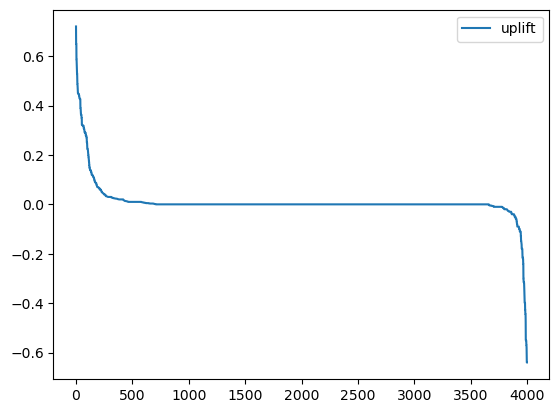

In [14]:
import matplotlib.pylab as plt
%matplotlib inline
uplift_df = valid.drop(columns=['Purchase']).copy()

uplift_df.Promotion_ord = 1
predTreatment = rfModel.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = rfModel.predict_proba(uplift_df)

upliftResult_rf = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_rf = upliftResult_rf.sort_values(by=['uplift'], ascending=False)
upliftResult_rf.reset_index().plot(x=None, y='uplift')
plt.show()

In [16]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
knnModel = KNeighborsClassifier(n_neighbors=11)
knnModel.fit(train.drop(columns=['Purchase']), train['Purchase'])

pred = knnModel.predict(valid.drop(columns=['Purchase']))
classificationSummary(valid.Purchase, pred)

Confusion Matrix (Accuracy 0.9870)

       Prediction
Actual    0    1
     0 3948    0
     1   52    0


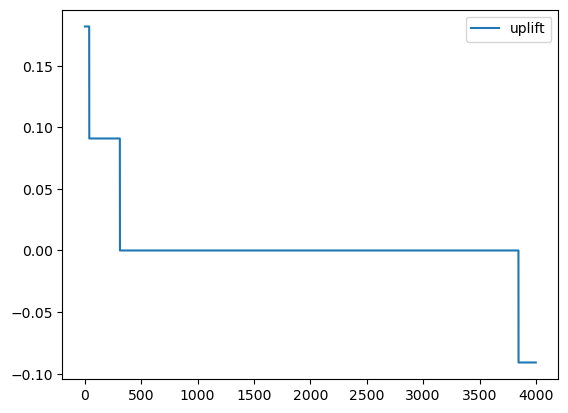

In [17]:
upliftt_df = valid.drop(columns=['Purchase']).copy()

uplift_df.Promotion_ord = 1
predTreatment = knnModel.predict_proba(uplift_df)
uplift_df.Promotion_ord = 0
predControl = knnModel.predict_proba(uplift_df)

upliftResult_knn = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'pronNoMessage': predControl[:, 1],
    'uplift': predTreatment[:, 1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_knn = upliftResult_knn.sort_values(by=['uplift'], ascending=False)
upliftResult_knn.reset_index().plot(x=None, y='uplift')
plt.show()


In [18]:
upliftResult_rf.head(3)

,probMessage,probNoMessage,uplift
6757,0.74,0.02,0.72
3380,0.67,0.02,0.65
4295,0.65,0.00,0.65


In [19]:
upliftResult_knn.head(3)

,probMessage,pronNoMessage,uplift
458,0.181818,0.0,0.181818
4919,0.181818,0.0,0.181818
5831,0.181818,0.0,0.181818
